In [1]:
import torch
from train_utils import *
import torchvision

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Cuda kontrol


In [3]:
train_dataset = PlateDataset(dataset_path="./platesv2/plates/train", csv_file_path="./platesv2/sample_submission.csv",mode="train")
test_dataset = PlateDataset(dataset_path="./platesv2/plates/test", csv_file_path="./platesv2/sample_submission.csv",mode="test")

In [4]:
label2id = train_dataset.label2id
id2label = train_dataset.id2label

In [5]:
train_loader, test_loader = getDataLoaders(train_dataset, test_dataset, batch_size=2)

/media/hosman/Codes/Plate Classifier/train_utils.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(img_label, dtype=torch.float32)


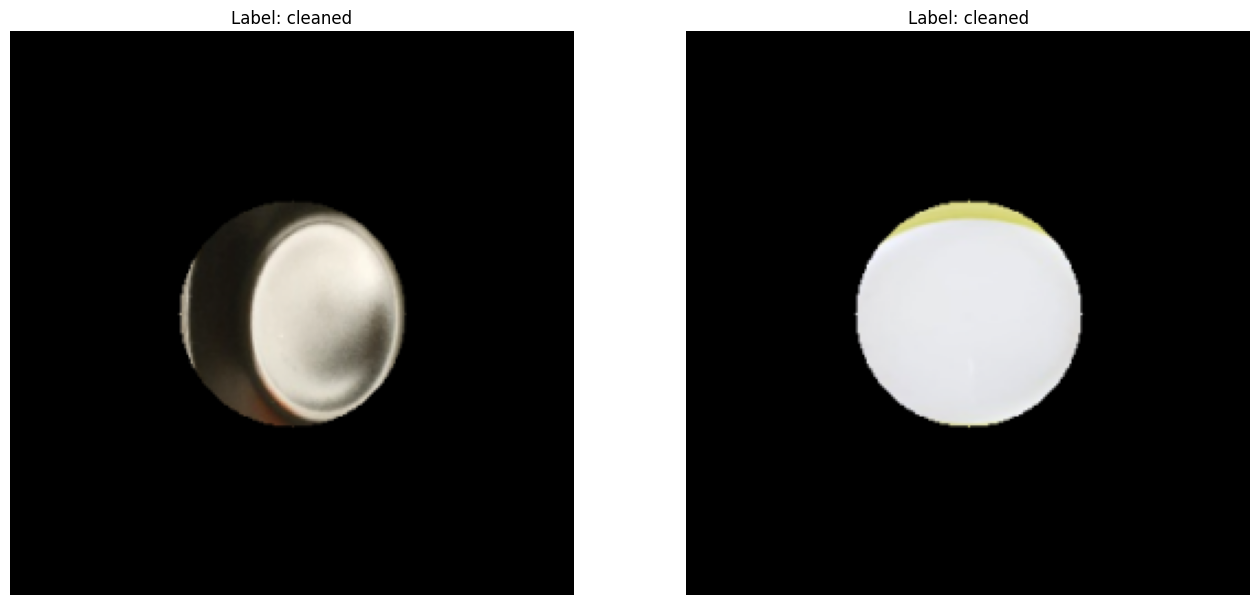

In [6]:
import torch
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

# Batch boyutunu al
batch_size = images.shape[0]


column_count = 2

# Her bir resmi çizmek için bir döngü başlat
fig, axes = plt.subplots(1, column_count, figsize=(batch_size * 8, 8))


for column in range(0, column_count):
  
    image = images[column]

    image = image / 255.0  

    image = image.permute(1, 2, 0).numpy()

    # Eğer görüntü float ise ve 0-1 aralığında değilse
    if image.dtype == np.float32 or image.dtype == np.float64:
        # Normalizasyon (0-1 aralığı)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize et

    # Görüntü türünü kontrol et ve uygun aralığa getir
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)  # 0-255 aralığına çevir
    else:
        image = image.astype(np.uint8)  # Zaten uint8 ise doğrudan kullan

    # Resmi çiz
    axes[column].imshow(image)
    axes[column].axis('off')  # Eksenleri kapat
    axes[column].set_title(f"Label: {id2label[str(int(labels[column].item()))]}")  # Label'ı yazdır

plt.show()


In [7]:
train_dataset = PlateDataset(dataset_path="./platesv2/plates/train",mode="train", transform=True)
test_dataset = PlateDataset(dataset_path="./platesv2/plates/test", csv_file_path="./platesv2/sample_submission.csv",mode="test", transform=False)

In [8]:
train_loader, test_loader = getDataLoaders(train_dataset, test_dataset, batch_size=2)

/media/hosman/Codes/Plate Classifier/train_utils.py:209: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img, dtype=torch.float32), torch.tensor(img_label, dtype=torch.float32)


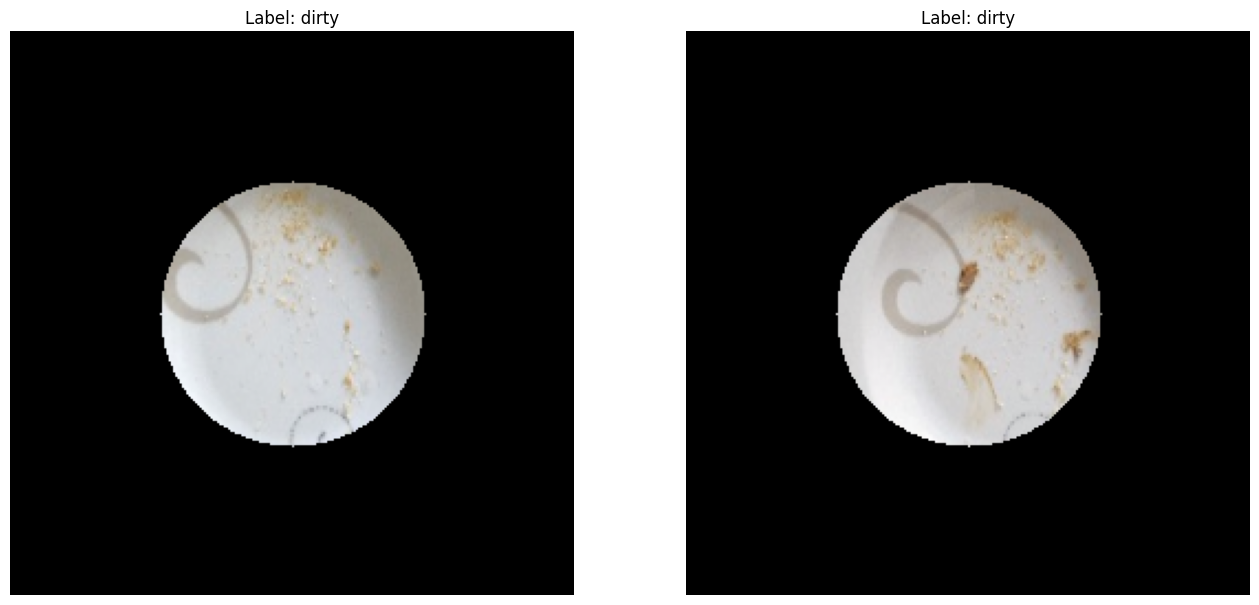

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(iter(train_loader))

# Batch boyutunu al
batch_size = images.shape[0]


column_count = 2

# Her bir resmi çizmek için bir döngü başlat
fig, axes = plt.subplots(1, column_count, figsize=(batch_size * 8, 8))


for column in range(0, column_count):
  
    image = images[column]
  
    image = image / 255.0  

    image = image.permute(1, 2, 0).numpy()
    
    # Eğer görüntü float ise ve 0-1 aralığında değilse
    if image.dtype == np.float32 or image.dtype == np.float64:
        # Normalizasyon (0-1 aralığı)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))  # Normalize et

    # Görüntü türünü kontrol et ve uygun aralığa getir
    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)  # 0-255 aralığına çevir
    else:
        image = image.astype(np.uint8)  # Zaten uint8 ise doğrudan kullan

    # Resmi çiz
    axes[column].imshow(image)
    axes[column].axis('off')  # Eksenleri kapat
    axes[column].set_title(f"Label: {id2label[str(int(labels[column].item()))]}")  # Label'ı yazdır

plt.show()


In [10]:
num_epochs = 50

In [11]:
model = PlateModel().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay = 0.005, momentum = 0.9)

In [12]:
# Eğitim verisi, batch boyutu ve epoch sayısı
dataset_size = len(train_loader)  # Eğitim veri seti boyutu
batch_size = 2

# Toplam adım sayısını hesapla
num_training_steps = (dataset_size // batch_size) * num_epochs

# Warmup ve toplam adım sayıları
num_warmup_steps = num_training_steps // num_epochs



def lr_lambda(current_step: int, num_warmup_steps: int, num_training_steps: int):
    if current_step < num_warmup_steps:
        return 0.001
    else:
        return 0.0001

In [13]:
# LambdaLR planlayıcıyı oluştur
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: lr_lambda(step, num_warmup_steps, num_training_steps))

In [14]:
def calculate_accuracy(outputs, labels):
    
    _, predicted = torch.max(outputs, 1)  # outputs şekli [batch_size, num_classes]
    
    
    correct = (predicted == labels).float().sum()  
    
    
    accuracy = correct / len(labels)  
    return accuracy

In [15]:
from tqdm import tqdm


best_accuracy = 0.0
best_model_path = 'best_model.pth'


for epoch in range(num_epochs):

    print(f"Epoch {epoch} eğitiliyor.")

    total_accuracy = 0
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

    model.train()
    for x, y in progress_bar:

        optimizer.zero_grad()

        x = x.to(device)
        y = y.to(device).long() # CrossEntropyLoss için etiketlerin long türünde olması gerekiyor

        outputs = model(x)

        loss = criterion(outputs, y)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()  
        accuracy = calculate_accuracy(outputs, y)  # Doğruluk hesaplaması güncellendi
        total_accuracy += accuracy  

        # Planlayıcıyı güncelle
        scheduler.step()

        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_accuracy / len(train_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')


    #En iyi model kontrolü
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        torch.save(model.state_dict(), best_model_path)
        print(f'En iyi model kaydedildi, doğruluk: {best_accuracy:.4f}')

# En iyi modeli yükle
model.load_state_dict(torch.load(best_model_path))
print('En iyi model yüklendi.')


Epoch 0 eğitiliyor.


Epoch 1/50: 100%|██████████| 20/20 [00:00<00:00, 27.46it/s, loss=0.658]


Epoch [1/50], Loss: 0.7485, Accuracy: 0.5000
En iyi model kaydedildi, doğruluk: 0.5000
Epoch 1 eğitiliyor.


Epoch 2/50: 100%|██████████| 20/20 [00:00<00:00, 56.34it/s, loss=0.718]


Epoch [2/50], Loss: 0.7099, Accuracy: 0.5750
En iyi model kaydedildi, doğruluk: 0.5750
Epoch 2 eğitiliyor.


Epoch 3/50: 100%|██████████| 20/20 [00:00<00:00, 96.07it/s, loss=0.879]


Epoch [3/50], Loss: 0.6708, Accuracy: 0.6000
En iyi model kaydedildi, doğruluk: 0.6000
Epoch 3 eğitiliyor.


Epoch 4/50: 100%|██████████| 20/20 [00:00<00:00, 69.61it/s, loss=0.843]


Epoch [4/50], Loss: 0.7214, Accuracy: 0.5500
Epoch 4 eğitiliyor.


Epoch 5/50: 100%|██████████| 20/20 [00:00<00:00, 70.65it/s, loss=0.819]


Epoch [5/50], Loss: 0.6936, Accuracy: 0.4750
Epoch 5 eğitiliyor.


Epoch 6/50: 100%|██████████| 20/20 [00:00<00:00, 74.37it/s, loss=0.657]


Epoch [6/50], Loss: 0.7073, Accuracy: 0.4000
Epoch 6 eğitiliyor.


Epoch 7/50: 100%|██████████| 20/20 [00:00<00:00, 69.61it/s, loss=0.665]


Epoch [7/50], Loss: 0.6866, Accuracy: 0.6250
En iyi model kaydedildi, doğruluk: 0.6250
Epoch 7 eğitiliyor.


Epoch 8/50: 100%|██████████| 20/20 [00:00<00:00, 66.51it/s, loss=0.679]


Epoch [8/50], Loss: 0.6921, Accuracy: 0.5250
Epoch 8 eğitiliyor.


Epoch 9/50: 100%|██████████| 20/20 [00:00<00:00, 76.56it/s, loss=0.678]


Epoch [9/50], Loss: 0.7216, Accuracy: 0.4250
Epoch 9 eğitiliyor.


Epoch 10/50: 100%|██████████| 20/20 [00:00<00:00, 59.66it/s, loss=0.776]


Epoch [10/50], Loss: 0.7291, Accuracy: 0.4250
Epoch 10 eğitiliyor.


Epoch 11/50: 100%|██████████| 20/20 [00:00<00:00, 52.95it/s, loss=0.657]


Epoch [11/50], Loss: 0.6789, Accuracy: 0.5250
Epoch 11 eğitiliyor.


Epoch 12/50: 100%|██████████| 20/20 [00:00<00:00, 67.11it/s, loss=0.705]


Epoch [12/50], Loss: 0.6753, Accuracy: 0.6500
En iyi model kaydedildi, doğruluk: 0.6500
Epoch 12 eğitiliyor.


Epoch 13/50: 100%|██████████| 20/20 [00:00<00:00, 69.05it/s, loss=0.648]


Epoch [13/50], Loss: 0.6749, Accuracy: 0.6750
En iyi model kaydedildi, doğruluk: 0.6750
Epoch 13 eğitiliyor.


Epoch 14/50: 100%|██████████| 20/20 [00:00<00:00, 49.13it/s, loss=0.585]


Epoch [14/50], Loss: 0.6929, Accuracy: 0.5000
Epoch 14 eğitiliyor.


Epoch 15/50: 100%|██████████| 20/20 [00:00<00:00, 52.03it/s, loss=0.78] 


Epoch [15/50], Loss: 0.6953, Accuracy: 0.5500
Epoch 15 eğitiliyor.


Epoch 16/50: 100%|██████████| 20/20 [00:00<00:00, 49.40it/s, loss=0.752]


Epoch [16/50], Loss: 0.6899, Accuracy: 0.6250
Epoch 16 eğitiliyor.


Epoch 17/50: 100%|██████████| 20/20 [00:00<00:00, 48.57it/s, loss=0.748]


Epoch [17/50], Loss: 0.6882, Accuracy: 0.5500
Epoch 17 eğitiliyor.


Epoch 18/50: 100%|██████████| 20/20 [00:00<00:00, 52.44it/s, loss=0.571]


Epoch [18/50], Loss: 0.6631, Accuracy: 0.5750
Epoch 18 eğitiliyor.


Epoch 19/50: 100%|██████████| 20/20 [00:00<00:00, 50.79it/s, loss=0.69] 


Epoch [19/50], Loss: 0.6723, Accuracy: 0.6500
Epoch 19 eğitiliyor.


Epoch 20/50: 100%|██████████| 20/20 [00:00<00:00, 48.03it/s, loss=0.543]


Epoch [20/50], Loss: 0.6754, Accuracy: 0.6250
Epoch 20 eğitiliyor.


Epoch 21/50: 100%|██████████| 20/20 [00:00<00:00, 51.54it/s, loss=0.599]


Epoch [21/50], Loss: 0.6864, Accuracy: 0.4250
Epoch 21 eğitiliyor.


Epoch 22/50: 100%|██████████| 20/20 [00:00<00:00, 48.44it/s, loss=0.862]


Epoch [22/50], Loss: 0.7297, Accuracy: 0.4000
Epoch 22 eğitiliyor.


Epoch 23/50: 100%|██████████| 20/20 [00:00<00:00, 49.96it/s, loss=0.586]


Epoch [23/50], Loss: 0.6664, Accuracy: 0.6750
Epoch 23 eğitiliyor.


Epoch 24/50: 100%|██████████| 20/20 [00:00<00:00, 49.63it/s, loss=0.619]


Epoch [24/50], Loss: 0.6764, Accuracy: 0.5000
Epoch 24 eğitiliyor.


Epoch 25/50: 100%|██████████| 20/20 [00:00<00:00, 53.81it/s, loss=0.673]


Epoch [25/50], Loss: 0.7025, Accuracy: 0.4750
Epoch 25 eğitiliyor.


Epoch 26/50: 100%|██████████| 20/20 [00:00<00:00, 49.32it/s, loss=0.682]


Epoch [26/50], Loss: 0.6805, Accuracy: 0.6000
Epoch 26 eğitiliyor.


Epoch 27/50: 100%|██████████| 20/20 [00:00<00:00, 47.28it/s, loss=0.663]


Epoch [27/50], Loss: 0.6620, Accuracy: 0.5250
Epoch 27 eğitiliyor.


Epoch 28/50: 100%|██████████| 20/20 [00:00<00:00, 51.10it/s, loss=0.736]


Epoch [28/50], Loss: 0.6458, Accuracy: 0.6500
Epoch 28 eğitiliyor.


Epoch 29/50: 100%|██████████| 20/20 [00:00<00:00, 51.31it/s, loss=0.598]


Epoch [29/50], Loss: 0.6545, Accuracy: 0.6000
Epoch 29 eğitiliyor.


Epoch 30/50: 100%|██████████| 20/20 [00:00<00:00, 49.99it/s, loss=0.768]


Epoch [30/50], Loss: 0.6823, Accuracy: 0.5250
Epoch 30 eğitiliyor.


Epoch 31/50: 100%|██████████| 20/20 [00:00<00:00, 50.90it/s, loss=0.879]


Epoch [31/50], Loss: 0.6864, Accuracy: 0.5750
Epoch 31 eğitiliyor.


Epoch 32/50: 100%|██████████| 20/20 [00:00<00:00, 49.72it/s, loss=0.697]


Epoch [32/50], Loss: 0.6877, Accuracy: 0.5000
Epoch 32 eğitiliyor.


Epoch 33/50: 100%|██████████| 20/20 [00:00<00:00, 49.09it/s, loss=0.865]


Epoch [33/50], Loss: 0.6968, Accuracy: 0.5000
Epoch 33 eğitiliyor.


Epoch 34/50: 100%|██████████| 20/20 [00:00<00:00, 53.11it/s, loss=0.794]


Epoch [34/50], Loss: 0.6512, Accuracy: 0.7250
En iyi model kaydedildi, doğruluk: 0.7250
Epoch 34 eğitiliyor.


Epoch 35/50: 100%|██████████| 20/20 [00:00<00:00, 48.59it/s, loss=0.556]


Epoch [35/50], Loss: 0.6653, Accuracy: 0.5750
Epoch 35 eğitiliyor.


Epoch 36/50: 100%|██████████| 20/20 [00:00<00:00, 47.77it/s, loss=0.653]


Epoch [36/50], Loss: 0.6550, Accuracy: 0.6750
Epoch 36 eğitiliyor.


Epoch 37/50: 100%|██████████| 20/20 [00:00<00:00, 49.70it/s, loss=0.54] 


Epoch [37/50], Loss: 0.6634, Accuracy: 0.6000
Epoch 37 eğitiliyor.


Epoch 38/50: 100%|██████████| 20/20 [00:00<00:00, 49.62it/s, loss=0.607]


Epoch [38/50], Loss: 0.6822, Accuracy: 0.5250
Epoch 38 eğitiliyor.


Epoch 39/50: 100%|██████████| 20/20 [00:00<00:00, 51.17it/s, loss=0.498]


Epoch [39/50], Loss: 0.7062, Accuracy: 0.4750
Epoch 39 eğitiliyor.


Epoch 40/50: 100%|██████████| 20/20 [00:00<00:00, 47.19it/s, loss=0.728]


Epoch [40/50], Loss: 0.6740, Accuracy: 0.5750
Epoch 40 eğitiliyor.


Epoch 41/50: 100%|██████████| 20/20 [00:00<00:00, 49.42it/s, loss=0.682]


Epoch [41/50], Loss: 0.6940, Accuracy: 0.5250
Epoch 41 eğitiliyor.


Epoch 42/50: 100%|██████████| 20/20 [00:00<00:00, 48.58it/s, loss=0.747]


Epoch [42/50], Loss: 0.6901, Accuracy: 0.4000
Epoch 42 eğitiliyor.


Epoch 43/50: 100%|██████████| 20/20 [00:00<00:00, 94.12it/s, loss=0.632]


Epoch [43/50], Loss: 0.6668, Accuracy: 0.5750
Epoch 43 eğitiliyor.


Epoch 44/50: 100%|██████████| 20/20 [00:00<00:00, 88.32it/s, loss=0.614]


Epoch [44/50], Loss: 0.6663, Accuracy: 0.5750
Epoch 44 eğitiliyor.


Epoch 45/50: 100%|██████████| 20/20 [00:00<00:00, 91.98it/s, loss=0.604] 


Epoch [45/50], Loss: 0.6594, Accuracy: 0.6000
Epoch 45 eğitiliyor.


Epoch 46/50: 100%|██████████| 20/20 [00:00<00:00, 89.42it/s, loss=0.479]


Epoch [46/50], Loss: 0.6667, Accuracy: 0.5500
Epoch 46 eğitiliyor.


Epoch 47/50: 100%|██████████| 20/20 [00:00<00:00, 67.15it/s, loss=0.933]


Epoch [47/50], Loss: 0.6687, Accuracy: 0.6250
Epoch 47 eğitiliyor.


Epoch 48/50: 100%|██████████| 20/20 [00:00<00:00, 66.94it/s, loss=0.587]


Epoch [48/50], Loss: 0.6862, Accuracy: 0.5250
Epoch 48 eğitiliyor.


Epoch 49/50: 100%|██████████| 20/20 [00:00<00:00, 71.72it/s, loss=0.733]


Epoch [49/50], Loss: 0.6225, Accuracy: 0.5500
Epoch 49 eğitiliyor.


Epoch 50/50: 100%|██████████| 20/20 [00:00<00:00, 65.99it/s, loss=0.579]
/tmp/ipykernel_201263/2577449195.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_sta

Epoch [50/50], Loss: 0.6930, Accuracy: 0.6000
En iyi model yüklendi.


In [16]:
import torch
import numpy as np

def evaluate_model_with_metrics(model, test_loader, criterion, device):
    model.eval()  

    correct_predictions = 0
    total_samples = 0
    total_loss = 0.0  

    with torch.no_grad():  
        for x, y in test_loader:
            x = x.to(device) 
            y = y.to(device).long()

            outputs = model(x)  
            loss = criterion(outputs, y)  
            total_loss += loss.item() * len(x)  

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == y).sum().item()
            total_samples += len(x)

    accuracy = correct_predictions / total_samples  # Doğruluk oranı
    average_loss = total_loss / total_samples  # Ortalama kayıp değeri

    return accuracy, average_loss


accuracy, average_loss = evaluate_model_with_metrics(model, test_loader, criterion, "cuda")
print(f" Loss: {average_loss:.4f}, Accuracy: {accuracy:.4f}")


 Loss: 0.6115, Accuracy: 0.8105


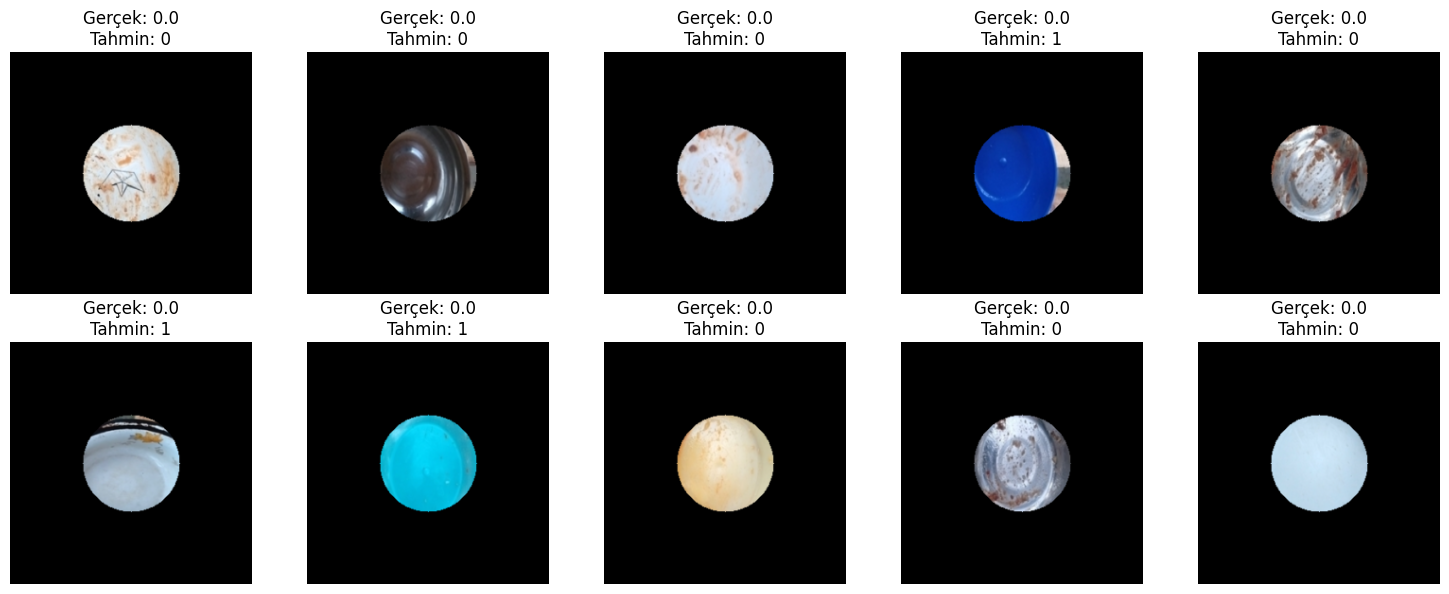

In [17]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, device, num_samples=10):
    model.eval()  

    data_iter = iter(test_loader)
    images, labels = next(data_iter)  

    images = images[:num_samples].to(device) 
    labels = labels[:num_samples]  

    with torch.no_grad():
        outputs = model(images)  
        _, predicted = torch.max(outputs, 1)  

    
    fig, axes = plt.subplots(2, num_samples // 2, figsize=(15, 6))
    for i in range(num_samples):
        ax = axes[i // (num_samples // 2), i % (num_samples // 2)]  
        image = images[i].cpu().numpy().transpose((1, 2, 0))  
        image = image - image.min()  
        image = image / image.max()
        ax.imshow(image)
        ax.set_title(f"Gerçek: {labels[i]}\nTahmin: {predicted[i]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


visualize_predictions(model, test_loader, "cuda", num_samples=10)


In [18]:
import torch
import pandas as pd
from torchvision import transforms
from PIL import Image
from torchvision.transforms import v2

def process_and_predict(model, csv_path, device, output_csv_path):
    # Verilen CSV dosyasını oku
    df = pd.read_csv(csv_path,dtype={'id': str, 'label': str})

    # Resim dosyalarını dönüştürmek için gerekli işlemler
    transform = transforms.Compose([
        v2.Resize((256, 256)),
        v2.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])

    # Modeli değerlendirme moduna geçir
    model.eval()

    # Tahmin ve gerçek değerler için listeler
    predictions = []
    true_labels = df['label'].tolist()  # Gerçek etiketleri CSV'den al

    correct_pred = 0 

    # Resimleri işleme ve tahmin yapma
    with torch.no_grad():
        for index, row in df.iterrows():

            image = read_image(os.path.join("platesv2/plates/test" ,(str(row["id"])+".jpg"))).to(dtype=torch.float32)

            image = v2.Resize((300, 300))(image)

            image = create_circular_mask_from_tensor(image, 0.4)
            image = transform(image).unsqueeze(0).to(device)  # Dönüşümleri uygula ve cihaza gönder

            # Model ile tahmin yap
            output = model(image)
            _, predicted = torch.max(output, 1)  # En yüksek olasılığa sahip sınıfı seç
            predictions.append(id2label[str(predicted.item())])

            correct_pred += 1 if id2label[str(predicted.item())] == row["label"] else 0

    # Tahminleri DataFrame'e ekle
    df['pred_label'] = predictions

    print(f"doğruluk oranı {(correct_pred/len(true_labels))}")

    # Yeni CSV dosyasını kaydet
    df.to_csv(output_csv_path, index=False)
    print(f"Tahminler kaydedildi: {output_csv_path}")

# Örneği çağırma
process_and_predict(model, 'platesv2/sample_submission.csv', 'cuda', 'tahminler.csv')


doğruluk oranı 0.8104838709677419
Tahminler kaydedildi: tahminler.csv
